# [모듈 1.2] Semantic Textual Similarity 모델 추론 스크래치


---


# 1. Setup Environments
---


#### 사용자 정의 라이브러러 환경 셋업 및 라이브러리 로딩

In [1]:
import sys

In [2]:
%load_ext autoreload
%autoreload 2

sys.path.append('src')

In [3]:
%store -r model_save_path

In [4]:
import os
import sys
import json
import logging
import argparse
import torch
import gzip
import csv
import math
import urllib
from torch import nn
import numpy as np
import pandas as pd
from tqdm import tqdm

from datetime import datetime
from datasets import load_dataset
from torch.utils.data import DataLoader
from sentence_transformers import SentenceTransformer, SentencesDataset, LoggingHandler, losses, models, util
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
# from sentence_transformers.readers import InputExample
# from transformers.trainer_utils import get_last_checkpoint

from os.path import exists

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S',
    handlers=[LoggingHandler()]
)

logger = logging.getLogger(__name__)

# 2. Semantic Search (News)


시멘틱(의미) 검색은 검색 쿼리가 키워드를 찾는 것뿐만 아니라, 검색에 사용되는 단어의 의도와 문맥적 의미를 파악하는 것을 목표로 합니다.
시멘틱 유사도 검색을 또한 챗봇 및 해당 검색 쿼리를 입력하면, 검색 쿼리의 임베딩을 계산하여 모든 문서(예: 뉴스 제목/요약, 웹페이지 제목/요약) 리스트의 임베딩을 비교하여 가장 유사도가 높은 문서 후보들을 찾습니다.

References
- Billion-scale semantic similarity search with FAISS+SBERT: https://towardsdatascience.com/billion-scale-semantic-similarity-search-with-faiss-sbert-c845614962e2
- Korean Contemporary Corpus of Written Sentences: http://nlp.kookmin.ac.kr/kcc/

## 2.1. Preparing news dataset

In [5]:
class Params:
    def __init__(self):
        self.train_dir = 'data/KorSTS/train/'        
                        
args = Params()
print("train_dir: ", args.train_dir)

train_dir:  data/KorSTS/train/


In [6]:
from custom_util import MyProgressBar
from os.path import exists
import zipfile

news_path = f'{args.train_dir}/KCCq28_Korean_sentences_EUCKR_v2.txt'
print("news_path: \n", news_path, "\n")
    
if exists(news_path):
    print("Data is available")    
    pass
else:
    print("No data So we are downloading file")
    url = 'http://nlp.kookmin.ac.kr/kcc/KCCq28_Korean_sentences_EUCKR_v2.zip'
    news_path = f'{args.train_dir}/KCCq28_Korean_sentences_EUCKR_v2.zip'
    urllib.request.urlretrieve(url, news_path, MyProgressBar())    
    
    with zipfile.ZipFile(news_path, 'r') as zip_ref:
        zip_ref.extractall(args.train_dir)




news_path: 
 data/KorSTS/train//KCCq28_Korean_sentences_EUCKR_v2.txt 

No data So we are downloading file


100% |########################################################################|


In [7]:
from custom_util import extract_news_data

news_data_raw = extract_news_data(args, news_path, logger)

2023-02-26 13:20:42 - news_data length:  1337721


## 2.2. News Data Sampling

- num_sample 을 에러시 조절 하세요.

In [8]:
num_sample = 20000

In [9]:
import random


def sample_news_data(num_sample, news_data_raw):
    random.seed(100)
    news_data = random.sample(news_data_raw, num_sample)
    #news_data = news_data_raw[:num_sample] # For debug purpose
    
    return news_data

corpus = sample_news_data(num_sample, news_data_raw)

In [10]:
corpus[0:3]

['그는 "터키 원전수주 계약은 일본 정부의 장기 위험 보증 조항에 달려 있다"고 덧붙였다.',
 '기재부 고위 관계자는 "김동연 부총리가 오고 지난해 예산안 통과 과정에서 예산실이 밤샘근무를 하루밖에 안 했다"며 "예산실장 출신이라 개선을 많이 하려고는 하는데 현장의 목소리를 더 들을 필요가 있다"고 꼬집었다.',
 '선수들을 지도하고 있는 원동현은 "이번 훈련을 통해 여자핸드볼 국가대표 선수들이 강인한 해병 정신으로 무장해 리우 올림픽에서 반드시 승리하도록 해병대가 견인차 역할을 할 것"이라며 "악조건 속에서도 전승을 거둬 온 해병대의 강한 훈련을 받은 만큼 선수들도 강한 자부심과 자신감을 갖게 될 것이라 확신한다"고 전했다.']

In [11]:
model = SentenceTransformer(model_save_path)

2023-02-26 13:20:42 - Load pretrained SentenceTransformer: /home/ec2-user/SageMaker/NLP-HuggingFace-On-SageMaker/3_Semantic-Textual-Similarity/3_Training/KorSTS/model/training_sts_sentence-transformers-xlm-r-100langs-bert-base-nli-stsb-mean-tokens-2023-02-26_13-18-02
2023-02-26 13:20:46 - Use pytorch device: cuda


## 2.3. 뉴스 데이터 Sentence-BERT Output Embedding

In [12]:
from custom_util import encode_multi_gpu_embedding 


corpus_embeddings = encode_multi_gpu_embedding(model, corpus) # 384 문장 임베딩 * 10,000 문장

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

In [13]:
from custom_util import semantic_search
from custom_util import Okt_tokenizer 

In [14]:
top_k = 5

queries = [
            '올 시즌 정규리그 35경기에서 23골을 작성한 손흥민은 이날 울버햄프턴을 상대로 득점에 \
            성공한 무함마드 살라흐(리버풀·23골)와 함께 정규리그 득점 공동 1위에 올랐다.\
            아시아 출신 선수가 EPL에서 득점왕에 오른 건 손흥민이 처음이다. \
            EPL뿐 아니라 유럽축구 5대 리그(잉글랜드·스페인·독일·프랑스·이탈리아)로 범위를 넓혀도 \
            아시아 선수 득점왕의 전례를 찾아보기 어렵다.'
          ]


### 2.3.1. Corpus: 원문, Query : 원문

In [15]:
# queries = [Okt_tokenizer(queries[0])]
semantic_search(model, corpus, corpus_embeddings, queries, top_k)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Query: 올 시즌 정규리그 35경기에서 23골을 작성한 손흥민은 이날 울버햄프턴을 상대로 득점에             성공한 무함마드 살라흐(리버풀·23골)와 함께 정규리그 득점 공동 1위에 올랐다.            아시아 출신 선수가 EPL에서 득점왕에 오른 건 손흥민이 처음이다.             EPL뿐 아니라 유럽축구 5대 리그(잉글랜드·스페인·독일·프랑스·이탈리아)로 범위를 넓혀도             아시아 선수 득점왕의 전례를 찾아보기 어렵다.

Top 5 most similar sentences in corpus:

(Score: 0.5232) 2번타자로 선발 출전하는 오지환은 "지난해 9타수 무안타였는데 이번에는 2번타자로 뛰는 만큼 출루를 많이 해서 우리 팀이 기세를 잡을 수 있도록 할 것"이라며 두 주먹을 불끈 쥐었다.
(Score: 0.4884) 올해 초 두산 유니폼을 입은 볼스테드는 "한 시즌을 다 뛰겠다"는 바람과는 달리 중도 퇴출의 비운을 맛봤다.
(Score: 0.4882) 분데스리가는 "레버쿠젠이 뮌헨과의 친선경기에서 1-2로 패했지만 새로 합류한 손흥민이 첫 골맛을 보는 성과를 얻었다"고 손흥민의 활약에 주목했다.
(Score: 0.4833) 메이저리그 공식 홈페이지 MLB.com의 '스포츠온어스'는 해외 영입 성공 사례를 소개하며 "미네소타는 박병호가 국제시장 FA 선수들이 MLB에 즉시 영향을 미친 최근의 사례가 되기를 희망하고 있다"고 전했다.
(Score: 0.4795) 슈틸리케 감독은 "구자철은 상황상 남태희와 비슷하다 생각한다"며 "남태희는 미얀마전에서 부여받은 시간 동안 자리를 충분히 메울 수 있다는 것을 보여줬다"고 설명했다 남태희는 지난 12일 수원월드컵경기장에서 열린 미얀마와의 2018 러시아월드컵 아시아지역 2차 예선 G조 5차전 경기에 후반 32분 구자철을 대신해 투입됐다.


### 2.3.2. Corpus: 원문, Query : 전처리, 토큰 (명사, 형용사)

In [16]:
queries = [Okt_tokenizer(queries[0])]
semantic_search(model, corpus, corpus_embeddings, queries, top_k)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Query: 시즌 정규 리그 경기 작성 손흥민 울버햄프턴 상대로 득점 성공하다 무함마드 살라 리버풀 정규 리그 득점 공동 아시아 출신 선수 득점 오른 손흥민 처음 아니다 유럽 축구 리그 잉글랜드 스페인 독일 프랑스 이탈리아 범위 아시아 선수 득점 전례 어렵다

Top 5 most similar sentences in corpus:

(Score: 0.5799) 정재훈 롯데 이적, 이종운 감독 "최선의 선택"롯데가 두산과 FA 계약을 맺은 좌완 에이스 장원준을 지명했다.
(Score: 0.5114) 영국 매체 스포츠 잉글리시는 이승우와 세 번째 골을 터뜨린 카를레스 알레나를 두고 "신비스러운 듀오"라고 칭찬했고 스페인 매체 마르카는 "클럽 최고의 두 선수인 이승우와 알레나가 득점을 책임졌다"고 전했다.
(Score: 0.4950) 한 일본 축구팬은 손흥민의 결승전 동점골을 두고 "역시 아시아의 에이스"라며 치켜세웠다.
(Score: 0.4907) 상대 에이스 로페즈를 상대로 7안타 2득점한 타선에 대해서도 "에이스를 상대로 대량득점을 기대할 수는 없지 않은가.꼭 필요한 점수를 얻어내는 SK다운 야구를 했다"고 호평했다.
(Score: 0.4819) 2번타자로 선발 출전하는 오지환은 "지난해 9타수 무안타였는데 이번에는 2번타자로 뛰는 만큼 출루를 많이 해서 우리 팀이 기세를 잡을 수 있도록 할 것"이라며 두 주먹을 불끈 쥐었다.


### 2.3.3 경제 뉴스

In [17]:
top_k = 5

queries = [
        '삼성전자의 2분기 확정 실적이 발표된 전일부터 이틀간 증권사 18곳에서 분석 보고서를 냈다.\
        대부분은 3분기가 더 부진할 것인 데다 주가는 한 차례 더 조정이 올 것이란 어두운 전망을 내놓았다.\
        우리나라 시총 1위 기업 주식이 이런데, 미국 장으로 옮기는 데 답인가, 어깨에서 사서 무릎에 팔게 생겼다' '호실적에도 떨어지고' '오늘도 기대했던 내가 바보다 \
        증권가도 떠나는 개미들을 붙잡을 만한 전망을 내놓지 못하는 상황이다. 하반기 실적은 더 암울할 것이라는 게 중론이어서다.'
        ]
# queries = [Okt_tokenizer(queries[0])]

semantic_search(model, corpus, corpus_embeddings, queries, top_k)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Query: 삼성전자의 2분기 확정 실적이 발표된 전일부터 이틀간 증권사 18곳에서 분석 보고서를 냈다.        대부분은 3분기가 더 부진할 것인 데다 주가는 한 차례 더 조정이 올 것이란 어두운 전망을 내놓았다.        우리나라 시총 1위 기업 주식이 이런데, 미국 장으로 옮기는 데 답인가, 어깨에서 사서 무릎에 팔게 생겼다호실적에도 떨어지고오늘도 기대했던 내가 바보다         증권가도 떠나는 개미들을 붙잡을 만한 전망을 내놓지 못하는 상황이다. 하반기 실적은 더 암울할 것이라는 게 중론이어서다.

Top 5 most similar sentences in corpus:

(Score: 0.5782) 외국인들이 중동사태 이전에도 신흥국에서 발을 빼 왔던데다 3월에 국내에서 금융통화위원회 및 기업들의 프리 실적 시즌이 기다리고 있고 해외에서도 중국 전국인민대표대회, 미국 경기지표 발표 등 넘어야 할 산들이 많다는 것.민상일 이트레이드증권 투자전략팀장은 "인플레이션 우려가 확산되는 가운데 중동사태라는 돌발악재가 더해지면서 외국인들의 매도세가 강화되는 모습"이라며 "당분간 외국인들이 국내 증시에서 적극적으로 매수에 나서기 어렵고 이 영향으로 코스피지수도 좀 더 조정을 받을 가능성이 크다"고 말했다.
(Score: 0.5760) 경기를 지켜본 온라인 축구 커뮤니티에선 "일본 그저께 경기에 비해서 체력을 무리하게 오버페이스 하진 않는데 전방 프레싱에 지역방어는 여전히 쓰고 있음.공격, 미들 프레싱하고 공격 다 한다고 체력쓰는 건 여전함" "일본 입장에서는 승리도 절실하거니와 분명히 한명의 수적 우위가 있는 상황이라서 무지막지한 공격을 퍼부어야하는 상황이라고 선수들은 인식들을 하고 있음에도 도저히 마음놓고 공격일변도를 펼치기는 힘든 상황이네요.후반은 전형적인 체력전, 집중력 싸움이 될 듯합니다" 등의 분석을 내놓고 있다.
(Score: 0.5719) 보고서는 "미국의 금리인상이 시작되더라도 진행속도가 느리게 진행되는 정도라면 우리나라의 경상수지 흑자, 

In [18]:
queries = [Okt_tokenizer(queries[0])]
semantic_search(model, corpus, corpus_embeddings, queries, top_k)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Query: 전자 확정 실적 발표 전일 이틀 증권사 분석 보고서 대부분 부진하다 주가 차례 조정 두운 전망 우리나라 기업 주식 이렇다 미국 어깨 사서 무릎 호실 오늘 기대하다 바보 증권 가도 개미 전망 상황 하반기 실적 암울하다 중론

Top 5 most similar sentences in corpus:

(Score: 0.6692) 김세중 신영증권 투자전략 팀장은 "오늘 하루만 놓고 보면 기관이 펀드에서 유입된 현금을 가지고 저가 매수를 했다고 볼 수 있다"면서 "대외 여건이 잠시 진정됐고, 금요일 급매물 탓에 주가가 펀더멘털 이상으로 과하게 빠졌다는 판단을 한 것"이라고 지적했다.
(Score: 0.6132) 최남곤 유안타증권 연구원은 "고액 연봉과 국정농단 연루 의혹에 시달리는 황창규 회장의 거취와 관련한 이슈가 주가에 부담으로 이어지고있고 연말까지는 관련 불확실성이 지속될 가능성이 있다"며 "그러나 이 이슈가 해결된 이후에는 주가는 상승 반전할 것"이라고 말했다.
(Score: 0.6127) 이와 관련 윤여삼 미래에셋대우증권 연구원은 "브렉시트만으로 글로벌 경기여건을 판단하는 것은 어렵지만 하반기 경기여건이 만만치 않다"라며 "채권은 매수 관점에서 사들여야 한다"며 금리가 급락할 수 있다고 전망했다.
(Score: 0.6069) 신한금융투자 투자분석부 시황팀은 "이날 코스피는 주요 수급주체의 매수세가 강하지 않은 가운데 개인투자자의 매도세가 우세했다"며 "코스닥 지수는 개인의 양도소득세 과표 확정을 위한 매도에 코스닥150지수 구성종목을 중심으로 하락세가 나타난 것이 특징"이라고 분석했다.
(Score: 0.6007) 한 IB업계 관계자는 "단기실적이 급감할 경우 신용평가사에서 이를 곧바로 신용등급에 반영하는데다 최근 한 번에 두 단계, 혹은 한 해에도 두 차례 이상 등급을 강등하는 경우가 발생해 보유채권 가치 하락을 우려한 기관들의 태도가 더욱 깐깐해 지고 있다"고 말했다.


# 3. Corpus 에 전처리 도입

## 3.1. DASK 병렬 클러스터 준비

In [19]:
from dask.distributed import Client
os.environ["TOKENIZERS_PARALLELISM"] = "True"

n_workers = 4
threads_per_worker = 4

try: 
    if das_client.status == 'running':
        print("DAS client is running")
        pass
    else:
        print("DAS client has been created")
        das_client = Client(n_workers=n_workers, threads_per_worker = threads_per_worker)        
except Exception:
    # client 생성이 안되어 있으면 아래로 생성
    print("DAS client has been created")
    das_client = Client(n_workers=n_workers, threads_per_worker = threads_per_worker)
    
das_client

DAS client has been created


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 16,Total memory: 239.87 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45087,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 239.87 GiB
Comm: tcp://127.0.0.1:42791,Total threads: 4
Dashboard: http://127.0.0.1:35497/status,Memory: 59.97 GiB
Nanny: tcp://127.0.0.1:41735,


## 3.2. 데이터 준비

Corpus 를 Pandas Dataframe 으로 로딩

In [20]:
df = pd.DataFrame(data=corpus, columns=['doc'])
print("df shape: ", df.shape)



df shape:  (20000, 1)


Pandas Dataframe 을 DAS DataFrame 으로 변경

In [21]:
import dask.dataframe as dd
ddf = dd.from_pandas(df, npartitions=n_workers)
ddf.compute()

,doc
0,"그는 ""터키 원전수주 계약은 일본 정부의 장기 위험 보증 조항에 달려 있다""고 덧붙였다."
1,"기재부 고위 관계자는 ""김동연 부총리가 오고 지난해 예산안 통과 과정에서 예산실이 ..."
2,"선수들을 지도하고 있는 원동현은 ""이번 훈련을 통해 여자핸드볼 국가대표 선수들이 강..."
3,"광 작가도 ""게임은 거의 처음 하는 작업인데 새로운 경험이 됐다."
4,"김동철 국민의당 원내대표도 강 후보자에 대해 ""도덕적 흠결도 많을뿐더러 그 흠결을 ..."
...,...
19995,"이어 ""감독 입장에서 휴식기는 엔진을 완전히 꺼버리는 시기가 절대 아니다""며 ""휴식..."
19996,"1심 구속만기 6개월이 끝나는 10월16일 자정을 기해 반드시 석방돼야 한다""고 주..."
19997,"그는 서·최 의원에 대한 소명절차에 대해 ""그 과정은 조금 잘 안 된 걸로 알고 있..."
19998,"침묵하며 지켜보는 다수의 국민이 있다""고 말했다."


DAS Dataframe 의 compute graph 보여 주기

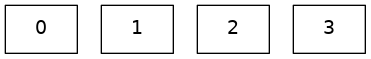

In [22]:
ddf.visualize()

## 3.3. 벙렬로 전처리 수행

n_worker = 4 로 n_thread=4 로 10,000 개시 30초, 20,000 개의 전처리시에 약 45초 걸립니다.

In [23]:
%%time

from IPython.display import display as dp
import traceback
from custom_util import remove_spec_chars

try: 
    # ddf["doc_cl"] = ddf["doc"].apply(preproces_doc, meta=('doc', 'object')).compute()      
    ddf["doc_cl"] = ddf["doc"].apply(remove_spec_chars, meta=('doc', 'object')).compute()      
    ddf["doc_cl"] = ddf["doc_cl"].apply(Okt_tokenizer,meta=('doc_cl', 'object') ).compute()      
    ddf["doc_cl"].compute()
except Exception:
    print(traceback.format_exc())    

CPU times: user 3.27 s, sys: 932 ms, total: 4.2 s
Wall time: 1min 4s


## 3.4. pandas df 로 변경

das dataframe 에서 pandas dataframe 으로 변경

In [24]:
pd_df = ddf.compute()
pd_df

,doc,doc_cl
0,"그는 ""터키 원전수주 계약은 일본 정부의 장기 위험 보증 조항에 달려 있다""고 덧붙였다.",터키 원전 수주 계약 일본 정부 장기 위험 보증 조항
1,"기재부 고위 관계자는 ""김동연 부총리가 오고 지난해 예산안 통과 과정에서 예산실이 ...",기재부 고위 관계자 김동연 부총리 지난해 예산안 통과 과정 산실 밤샘 근무 하루 예...
2,"선수들을 지도하고 있는 원동현은 ""이번 훈련을 통해 여자핸드볼 국가대표 선수들이 강...",선수 지도 동현 이번 훈련 통해 여자 핸드볼 국가대표 선수 강인하다 해병 정신 무장...
3,"광 작가도 ""게임은 거의 처음 하는 작업인데 새로운 경험이 됐다.",작가 게임 거의 처음 작업 새롭다 경험
4,"김동철 국민의당 원내대표도 강 후보자에 대해 ""도덕적 흠결도 많을뿐더러 그 흠결을 ...",김동철 국민의당 원내대표 후보자 대해 도덕 흠결 많다 흠결 자질 역량 없다 혹평 외...
...,...,...
19995,"이어 ""감독 입장에서 휴식기는 엔진을 완전히 꺼버리는 시기가 절대 아니다""며 ""휴식...",감독 입장 휴식 엔진 완전하다 시기 절대 아니다 휴식 동안 계속 엔진 후반기 선수 ...
19996,"1심 구속만기 6개월이 끝나는 10월16일 자정을 기해 반드시 석방돼야 한다""고 주...",구속 만기 개월 자정 기해 반드시 석방 주장
19997,"그는 서·최 의원에 대한 소명절차에 대해 ""그 과정은 조금 잘 안 된 걸로 알고 있...",의원 대한 소명 절차 대해 과정 조금 왜냐면 현재 국정감사 외국 때문
19998,"침묵하며 지켜보는 다수의 국민이 있다""고 말했다.",침묵 다수 국민


## 3.5. DASK Cluster 셧다운

In [25]:
import time

das_client.shutdown()
time.sleep(5)

2023-02-26 13:22:32,743 - distributed.nanny - WARNING - Worker process still alive after 3.2 seconds, killing


## 3.6. (옵션) DASK 에러시에 아래 주석을 제거하고 작업 하세요.
- 10,000 개 실행시에 약 2분 40초 걸림

In [26]:
# %%time
        
# from custom_util import preprocess_doc

# pd_df = preprocess_doc(df)

# 4. 전처리 도입 후에 추론

전처리된 Corpus를 embedding encoding 형태로 변경

In [27]:
corpus_cl = pd_df['doc_cl'].tolist()
corpus_embeddings_cl = encode_multi_gpu_embedding(model, corpus_cl)

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

## 4.1. Corpus: 전처리, Query : 전처리, 토큰 (명사, 형용사)

In [28]:
top_k = 5

queries = [
            '올 시즌 정규리그 35경기에서 23골을 작성한 손흥민은 이날 울버햄프턴을 상대로 득점에 \
            성공한 무함마드 살라흐(리버풀·23골)와 함께 정규리그 득점 공동 1위에 올랐다.\
            아시아 출신 선수가 EPL에서 득점왕에 오른 건 손흥민이 처음이다. \
            EPL뿐 아니라 유럽축구 5대 리그(잉글랜드·스페인·독일·프랑스·이탈리아)로 범위를 넓혀도 \
            아시아 선수 득점왕의 전례를 찾아보기 어렵다.'
          ]

queries = [Okt_tokenizer(queries[0])]
queries
semantic_search(model, corpus_cl, corpus_embeddings_cl, queries, top_k)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Query: 시즌 정규 리그 경기 작성 손흥민 울버햄프턴 상대로 득점 성공하다 무함마드 살라 리버풀 정규 리그 득점 공동 아시아 출신 선수 득점 오른 손흥민 처음 아니다 유럽 축구 리그 잉글랜드 스페인 독일 프랑스 이탈리아 범위 아시아 선수 득점 전례 어렵다

Top 5 most similar sentences in corpus:

(Score: 0.6126) 최형우 올스타전 홈런 레이스 목표 아웃 개도 같다 올스타전 경기 괜찮다 홈런 레이스 긴장
(Score: 0.5729) 오재영 경기 초반 점수 지난 경기 마찬가지 야수 도움 지난 경기 초반 점수 안일하다 오늘 같다 경우 최소 실점 위해 최선 소감
(Score: 0.5728) 경기 손흥민 구단 공식 퍼스 인터뷰 통해 준결승 웸블리 스타디움 중요하다 경기 승리 해트트릭 기록 정말 어렵다 기쁘다 승리 더욱 행복하다 소감
(Score: 0.5714) 한화 구단 용병 후보 히스 선수 대한 아웃 결과 최종 입하 결정
(Score: 0.5488) 상대 에이스 로페즈 상대로 안타 득점 대해 서도 에이스 상대로 대량 득점 기대하다 없다 필요하다 점수 다운 야구 호평


In [29]:
top_k = 5

queries = [
        '삼성전자의 2분기 확정 실적이 발표된 전일부터 이틀간 증권사 18곳에서 분석 보고서를 냈다.\
        대부분은 3분기가 더 부진할 것인 데다 주가는 한 차례 더 조정이 올 것이란 어두운 전망을 내놓았다.\
        우리나라 시총 1위 기업 주식이 이런데, 미국 장으로 옮기는 데 답인가, 어깨에서 사서 무릎에 팔게 생겼다' '호실적에도 떨어지고' '오늘도 기대했던 내가 바보다 \
        증권가도 떠나는 개미들을 붙잡을 만한 전망을 내놓지 못하는 상황이다. 하반기 실적은 더 암울할 것이라는 게 중론이어서다.'
        ]


queries = [Okt_tokenizer(queries[0])]
queries
semantic_search(model, corpus_cl, corpus_embeddings_cl, queries, top_k)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Query: 전자 확정 실적 발표 전일 이틀 증권사 분석 보고서 대부분 부진하다 주가 차례 조정 두운 전망 우리나라 기업 주식 이렇다 미국 어깨 사서 무릎 호실 오늘 기대하다 바보 증권 가도 개미 전망 상황 하반기 실적 암울하다 중론

Top 5 most similar sentences in corpus:

(Score: 0.6770) 다른 증권사 연구원 오버 이슈 상장 차례 주가 조정 조정 주식 매수 나쁘다 선택
(Score: 0.6672) 관련 윤여삼 미래에셋 대우 증권 연구원 브렉 시트 글로벌 여건 판단 어렵다 하반기 여건 라며 채권 매수 관점 금리 급락 전망
(Score: 0.6564) 서상영 증권 연구원 한국 증시 미국 증시 강세 상회 차익 실현 매물 하락 전환 운송업 종이 전날 부진하다 미국 판매량 발표 여파 코스피 하락 주도하다 설명
(Score: 0.6522) 김세중 증권 투자 전략 오늘 하루 기관 펀드 유입 현금 가지 저가 매수 면서 대외 여건 잠시 진정 금요일 매물 주가 펀더 멘털 이상 판단 지적
(Score: 0.6311) 투자 증권 박종렬 연구원 단기간 영업 실적 개선 통한 주가 평가 보지 무엇 청산 가치 대비 평가 상태 라며 그룹 경영 비리 수사 신동빈 회장 구속영장 기각 최악 상황 향후 경영 정상화 빠르다 진행


# (실행 제외 합니다.) 
5. Semantic Search (상품 리뷰)

- 아래의 데이터 파일은 비공개이어서, 이 섹션은 실행은 제외 하세요.

## 5.1. 데이터 준비

In [30]:
product_best_data_file = 'data/product_review/best_sample.json'

In [31]:
import json

with open(product_best_data_file) as json_file:
    best_review_data = json.load(json_file)
    
best_df = pd.DataFrame(best_review_data)
best_df.rename(columns={'contents' : 'doc'}, inplace=True)
best_df

FileNotFoundError: [Errno 2] No such file or directory: 'data/product_review/best_sample.json'

In [ ]:
%%time
pd.set_option('max_colwidth', 1000)

from custom_util import preprocess_doc

best_df_cl = preprocess_doc(best_df)
best_df_cl

## 5.2. Corpus: 원문, Query : 원문

In [ ]:
corpus = best_df_cl['doc'].tolist()
corpus_pd_review_embeddings = encode_multi_gpu_embedding(model, corpus)

In [ ]:
    
top_k = 3

queries = [ '가격 : 할인가 개당 3,720원 (2개 이상 구입 필수) 양 : 1인분으로 평범한 양, \
            점심에 먹는 것을 추천 조리시간 및 난이도 : 약 7분, 라면 끓이는 수준의 난이도 평가 : 시중에 파는 \
            우동이 2천원대라는 점을 비교하면 3천원대로 나름 고급형 우동을 집에서 편하게 먹을 수 있어요. \
            어묵 사이즈는 여성 손바닥 정도이고, 한장 크게 들어가있어서 먹으면서 잘라 먹거나 베어 먹으면 됩니다. \
            국물과 어묵이 맛있어서 우동면 하나도 남기지 않고 다 먹었어요. \
            고추우동이라서 살짝 매콤한가 했는데 전혀 맵지 않고 칼칼함도 없이 시원하고 짭쫄한 맛입니다. \
            조리 방법은 뒷면에 상세하게 나와있어서 라면 끓일 줄 아는 분들이면 쉽게 따라할 수 있을거에요. \
            저는 설명서에 다른 채소와 함께 끓이면 더 맛있다고 하여 알배기배추 작은 거 추가해줬더니 씹는 맛이 일품이네요. \
            냉장고에 남는 채소 있으면 같이 끓이시는 것 추천! 맛있게 잘 먹었습니다 :)'
          ]
# queries = [Okt_tokenizer(queries[0])]
# queries
semantic_search(model, corpus, corpus_pd_review_embeddings, queries, top_k)

## 5.3. Corpus: 전처리, Query : 전처리, 토큰 (명사, 형용사)

In [ ]:
corpus_cl = best_df_cl['doc_cl'].tolist()
corpus_pd_review_embeddings_cl = encode_multi_gpu_embedding(model, corpus_cl)

In [ ]:
    
top_k = 3

queries = [ '가격 : 할인가 개당 3,720원 (2개 이상 구입 필수) 양 : 1인분으로 평범한 양, \
            점심에 먹는 것을 추천 조리시간 및 난이도 : 약 7분, 라면 끓이는 수준의 난이도 평가 : 시중에 파는 \
            우동이 2천원대라는 점을 비교하면 3천원대로 나름 고급형 우동을 집에서 편하게 먹을 수 있어요. \
            어묵 사이즈는 여성 손바닥 정도이고, 한장 크게 들어가있어서 먹으면서 잘라 먹거나 베어 먹으면 됩니다. \
            국물과 어묵이 맛있어서 우동면 하나도 남기지 않고 다 먹었어요. \
            고추우동이라서 살짝 매콤한가 했는데 전혀 맵지 않고 칼칼함도 없이 시원하고 짭쫄한 맛입니다. \
            조리 방법은 뒷면에 상세하게 나와있어서 라면 끓일 줄 아는 분들이면 쉽게 따라할 수 있을거에요. \
            저는 설명서에 다른 채소와 함께 끓이면 더 맛있다고 하여 알배기배추 작은 거 추가해줬더니 씹는 맛이 일품이네요. \
            냉장고에 남는 채소 있으면 같이 끓이시는 것 추천! 맛있게 잘 먹었습니다 :)'
          ]
queries = [Okt_tokenizer(queries[0])]
queries
semantic_search(model, corpus, corpus_pd_review_embeddings, queries, top_k)

## 5.4. Non-Best Review (???) - Corpus: 전처리, Query : 전처리, 토큰 (명사, 형용사)

In [ ]:
    
top_k = 3

queries = [ '매콤어묵도 깔끔한 맛이에요']
queries = [Okt_tokenizer(queries[0])]
queries
semantic_search(model, corpus, corpus_pd_review_embeddings_cl, queries, top_k)

In [ ]:
    
top_k = 3

queries = [ '한개가 간장소스가 다 터져서 문의글 남기면서 보니, \
            간장 터져서 왔다는 글이 많이 보이네요. 맛있는데 불안해서 또 시킬 수 있을지 모르겠네요ㅜㅜ'
          ]
queries = [Okt_tokenizer(queries[0])]
queries
semantic_search(model, corpus, corpus_pd_review_embeddings_cl, queries, top_k)

2023-02-26 13:23:02,886 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
